# A Comparative Study of  End-to-End Training and Layer-wise Training

## Group Members:

Naveen Isukapatla(ni82)<br>
Meghna Reddi(mr936)<br>
Shiva Karthik(sp3254)<br>




## Problem Statement

 In this project, we will test the hypothesis that layerwise training of neural networks has a different implicit bias than gradient descent training of neural networks. Our aim is to show this using a few different metrics:


 Test error - do the above 3 algorithms achieve similar performance?

 Norm of the neural network - do the above 3 algorithms find the same solutions in terms of the norm (defined as products of the norms of all the layers)?

## End-to-End Training

End-to-end training refers to a training approach in machine learning where the entire system or model is trained directly on input data to produce the desired output, without breaking it down into separate stages or components.

In the context of neural networks, end-to-end training involves training the entire neural network model, including all its layers, from input to output, using backpropagation and gradient descent or its variants. This means that the model learns to extract relevant features directly from the raw input data and to map it to the desired output in a single step, without the need for manual feature engineering or intermediate processing stages.

In [180]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Optimizer
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import backend as K


In [181]:
def load_data():
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train = x_train / 255.0
    x_test = x_test/ 255.0
    y_train = to_categorical(y_train, 10)
    y_test = to_categorical(y_test, 10)

    return x_train, y_train, x_test, y_test

## Stochastic Gradient Descent( End to End Model)

Stochastic Gradient Descent (SGD) is a widely used optimization algorithm for training machine learning models, including neural networks. It is a variant of the standard Gradient Descent algorithm, designed to handle large datasets efficiently.

In traditional Gradient Descent, the model parameters (e.g., weights and biases in a neural network) are updated based on the average gradient of the loss function computed over the entire training dataset. This means that the gradient is computed by summing up the gradients of the loss function for each training example, which can be computationally expensive, especially for large datasets.

SGD addresses this issue by updating the model parameters using the gradient of the loss function computed for only a single training example (or a small subset of examples) at each iteration. This results in much faster updates, as only a fraction of the data needs to be processed for each update step.

In [182]:
end_norms=[]
def baseline_model():
    model = Sequential([
        Flatten(input_shape=(28, 28)),
        Dense(128, activation='relu'),
        Dense(256, activation='relu'),
        Dense(10, activation='softmax')
    ])
    return model
x_train,y_train,x_test,y_test = load_data()
# Define the SGD optimizer
sgd = SGD(lr=0.03)

# Get the model
model = baseline_model()

# Compile the model
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
test_accuracy_history_baseline = []
# Train the model
no_epochs = 15
for epoch in range(no_epochs):
    print(f'Epoch {epoch+1}/{no_epochs}')
    history = model.fit(x_train, y_train, batch_size=32, epochs=1)
    _, test_accuracy = model.evaluate(x_test, y_test, verbose=0)
    test_accuracy_history_baseline.append(test_accuracy)
    
for layer in model.layers:
    modelend_weights = layer.get_weights()
    modelend_norm = np.linalg.norm([np.linalg.norm(w) for w in modelend_weights])  
    end_norms.append(modelend_norm)
print(end_norms)
print(test_accuracy_history_baseline)
# Evaluate the model on test data
loss, accuracy = model.evaluate(x_test, y_test)
print(f'\nTest Loss: {loss:.4f}')
print(f'Test Accuracy: {accuracy:.4f}')

Epoch 1/15
1875/1875 [==============================] - 6s 3ms/step - loss: 0.6425 - accuracy: 0.8328
Epoch 2/15
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2971 - accuracy: 0.9139
Epoch 3/15
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2451 - accuracy: 0.9293
Epoch 4/15
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2114 - accuracy: 0.9394
Epoch 5/15
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1869 - accuracy: 0.9469
Epoch 6/15
1875/1875 [==============================] - 5s 3ms/step - loss: 0.1671 - accuracy: 0.9525
Epoch 7/15
1875/1875 [==============================] - 5s 3ms/step - loss: 0.1516 - accuracy: 0.9563
Epoch 8/15
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1382 - accuracy: 0.9608
Epoch 9/15
1875/1875 [==============================] - 5s 3ms/step - loss: 0.1266 - accuracy: 0.9640
Epoch 10/15
1875/1875 [==============================] - 4s 2ms/step - loss: 0.117

In [183]:
End2End_ta_sgd=test_accuracy_history_baseline[-1]
End2End_ta_sgd

0.9706000089645386

In [184]:
End2End_norm_SGD=np.prod(end_norms[1:])
End2End_norm_SGD

1753.5505

## Coordinate-Descent

Coordinate Descent is an optimization algorithm used for minimizing a multivariate function. In the context of training neural networks, Coordinate Descent can be used as an alternative optimization method to algorithms like Stochastic Gradient Descent (SGD).

The idea behind Coordinate Descent is to iteratively update the parameters of the model one at a time, while keeping all other parameters fixed. At each iteration, the algorithm selects a single parameter or a group of parameters (a coordinate) to update based on a certain criterion, such as the steepest descent direction or the coordinate with the largest gradient.

In [185]:
class CoordinateDescentOptimizer(Optimizer):
    def __init__(self,name='CoordinateDescentOptimizer', alpha=0.03, num_iters=15, **kwargs):
        super().__init__(name=name,**kwargs)
        self._learning_rate = alpha
        self.num_iters = num_iters
        self.alpha = alpha
        
    def get_updates(self, loss, params):
        grads = self.get_gradients(loss, params)
        updates = []

        for param, grad in zip(params, grads):
            theta = K.get_value(param)
            for i in range(self.num_iters):
                predictions = self.softmax(X @ theta)
                for j in range(theta.shape[1]):
                    gradient = self.gradient_categorical_cross_entropy(X, y, theta, predictions)[:, j]
                    theta[:, j] = theta[:, j] - self.alpha * gradient
                J = self.categorical_cross_entropy(X, y, theta)
            updates.append((param, theta))
            learning_rate = self.alpha
        
        return updates

    def update_step(self, gradients, variables):
        updates = []
        for gradient, variable in zip(gradients, variables):
            new_variable = variable - self.alpha * gradient
            updates.append((variable, new_variable))
        return updates

    def apply_gradients(self, grads_and_vars):
        gradients, variables = zip(*grads_and_vars)
        updates = self.update_step(gradients, variables)
        for update in updates:
            K.update(update[0], update[1])

    def categorical_cross_entropy(self, X, y, theta):
        m = len(y)
        n_classes = theta.shape[1]
        logits = X.dot(theta)
        exp_logits = np.exp(logits - np.max(logits, axis=1, keepdims=True))
        softmax_probs = exp_logits / np.sum(exp_logits, axis=1, keepdims=True)
        y_one_hot = np.zeros_like(softmax_probs)
        y_labels = np.argmax(y, axis=1)
        y_one_hot[np.arange(m), y_labels] = 1

        loss = -np.sum(y_one_hot * np.log(softmax_probs + 1e-15)) / m

        return loss

    def softmax(self, x):
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)

    def gradient_categorical_cross_entropy(self, X, y, theta, predictions):
        m, n = X.shape
        C = theta.shape[1]
        gradient = np.zeros_like(theta)
        for j in range(C):
            for k in range(n):
                gradient[k, j] = np.sum(X[:, k] * (predictions[:, j] - (y[:, j])))

        return gradient / m

In [186]:
from tensorflow.keras.optimizers import Optimizer
end_norms=[]
def baseline_model():
    model = Sequential([
        Flatten(input_shape=(28, 28)),
        Dense(128, activation='relu'),
        Dense(256, activation='relu'),
        Dense(10, activation='softmax')
    ])
    return model
x_train,y_train,x_test,y_test = load_data()

# Get the model
model = baseline_model()

# Compile the model
model.compile(optimizer=CoordinateDescentOptimizer(name='CD_Optimizer'), loss='categorical_crossentropy', metrics=['accuracy'])
test_accuracy_history_baseline_cd = []
# Train the model
no_epochs = 15
for epoch in range(no_epochs):
    print(f'Epoch {epoch+1}/{no_epochs}')
    history = model.fit(x_train, y_train, batch_size=32, epochs=1)
    _, test_accuracy = model.evaluate(x_test, y_test, verbose=0)
    test_accuracy_history_baseline_cd.append(test_accuracy)
for layer in model.layers:
    modelend_weights = layer.get_weights()
    modelend_norm = np.linalg.norm([np.linalg.norm(w) for w in modelend_weights])  
    end_norms.append(modelend_norm)
print(end_norms)
print(test_accuracy_history_baseline_cd)

# Evaluate the model on test data
loss, accuracy = model.evaluate(x_test, y_test)
print(f'\nTest Loss: {loss:.4f}')
print(f'Test Accuracy: {accuracy:.4f}')

Epoch 1/15
1875/1875 [==============================] - 4s 2ms/step - loss: 0.4170 - accuracy: 0.8838
Epoch 2/15
1875/1875 [==============================] - 5s 3ms/step - loss: 0.1998 - accuracy: 0.9413
Epoch 3/15
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1465 - accuracy: 0.9570
Epoch 4/15
1875/1875 [==============================] - 5s 3ms/step - loss: 0.1158 - accuracy: 0.9662
Epoch 5/15
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0952 - accuracy: 0.9721
Epoch 6/15
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0797 - accuracy: 0.9768
Epoch 7/15
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0689 - accuracy: 0.9796
Epoch 8/15
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0600 - accuracy: 0.9824
Epoch 9/15
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0526 - accuracy: 0.9850
Epoch 10/15
1875/1875 [==============================] - 6s 3ms/step - loss: 0.047

In [187]:
End2End_ta_cd=test_accuracy_history_baseline_cd[-1]
End2End_ta_cd

0.9782000184059143

In [188]:
End2End_norm_CD=np.prod(end_norms[1:])
End2End_norm_CD

2498.8171

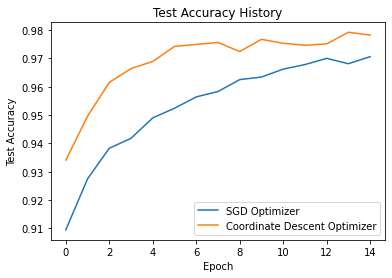

In [189]:
import matplotlib.pyplot as plt

# Plot test accuracy history for SGD optimizer
plt.plot(test_accuracy_history_baseline, label='SGD Optimizer')
# Plot test accuracy history for Coordinate Descent optimizer
plt.plot(test_accuracy_history_baseline_cd, label='Coordinate Descent Optimizer')

plt.title('Test Accuracy History')
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy')
plt.legend()
plt.show()


## Layer-wise Training

Layer-wise training, also known as layer-wise pretraining, is a technique used in training deep neural networks. It involves training each layer of the network sequentially, one at a time, while keeping the other layers fixed. This is in contrast to traditional end-to-end training, where all layers of the network are trained simultaneously.

The process of layer-wise training typically involves the following steps:

Initialization: Initialize the parameters of the entire network, usually using random or pre-trained weights.
Layer-wise Training:
Train the first layer of the network using the input data. This involves updating the parameters (e.g., weights and biases) of only the first layer while keeping the parameters of the other layers fixed.
Once the first layer is trained, freeze its parameters and move on to train the next layer in a similar manner.
Repeat this process until all layers have been trained.

Fine-tuning: After layer-wise training is completed, fine-tuning can be applied to the entire network. Fine-tuning involves unfreezing all layers of the network and jointly training them using backpropagation with a smaller learning rate.
Layer-wise training was popularized by the "greedy layer-wise pretraining" approach used in Restricted Boltzmann Machines (RBMs) and Deep Belief Networks (DBNs). It was found to be effective in initializing the parameters of deep neural networks, especially when labeled data is scarce. Layer-wise training can help in mitigating the problem of vanishing gradients and can lead to better convergence during training.


In [190]:
def create_model():
  model = Sequential([
      Flatten(input_shape=(28, 28)),
        Dense(128, activation='relu'),
        Dense(256, activation='relu'),
        Dense(10, activation='softmax')
  ])
  return model

In [191]:
def load_data():
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train = x_train / 255.0
    x_test = x_test/ 255.0
    y_train = to_categorical(y_train, 10)
    y_test = to_categorical(y_test, 10)

    return x_train, y_train, x_test, y_test

In [192]:
import numpy as np
from tensorflow.keras.optimizers import Optimizer
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import backend as K

class CoordinateDescentOptimizer(Optimizer):
    def __init__(self,name='CoordinateDescentOptimizer', alpha=0.03, num_iters=20, **kwargs):
        super().__init__(name=name,**kwargs)
        self._learning_rate = alpha
        self.num_iters = num_iters
        self.alpha = alpha
        
    def get_updates(self, loss, params):
        grads = self.get_gradients(loss, params)
        updates = []

        for param, grad in zip(params, grads):
            theta = K.get_value(param)
            for i in range(self.num_iters):
                predictions = self.softmax(X @ theta)
                for j in range(theta.shape[1]):
                    gradient = self.gradient_categorical_cross_entropy(X, y, theta, predictions)[:, j]
                    theta[:, j] = theta[:, j] - self.alpha * gradient
                J = self.categorical_cross_entropy(X, y, theta)
            updates.append((param, theta))
            learning_rate = self.alpha
        
        return updates

    def update_step(self, gradients, variables):
        updates = []
        for gradient, variable in zip(gradients, variables):
            new_variable = variable - self.alpha * gradient
            updates.append((variable, new_variable))
        return updates

    def apply_gradients(self, grads_and_vars):
        gradients, variables = zip(*grads_and_vars)
        updates = self.update_step(gradients, variables)
        for update in updates:
            K.update(update[0], update[1])

    def categorical_cross_entropy(self, X, y, theta):
        m = len(y)
        n_classes = theta.shape[1]
        logits = X.dot(theta)
        exp_logits = np.exp(logits - np.max(logits, axis=1, keepdims=True))
        softmax_probs = exp_logits / np.sum(exp_logits, axis=1, keepdims=True)
        y_one_hot = np.zeros_like(softmax_probs)
        y_labels = np.argmax(y, axis=1)
        y_one_hot[np.arange(m), y_labels] = 1

        loss = -np.sum(y_one_hot * np.log(softmax_probs + 1e-15)) / m

        return loss

    def softmax(self, x):
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)

    def gradient_categorical_cross_entropy(self, X, y, theta, predictions):
        m, n = X.shape
        C = theta.shape[1]
        gradient = np.zeros_like(theta)
        for j in range(C):
            for k in range(n):
                gradient[k, j] = np.sum(X[:, k] * (predictions[:, j] - (y[:, j])))

        return gradient / m


### Layer-wise CD

In [193]:
layer_norms_cd = []
layer_test_accuracy_histories_cd = []
#sgd = SGD(lr=0.03)
num_epochs = 5
x_train, y_train, x_test, y_test = load_data()
model = create_model()
optimizer_cd = CoordinateDescentOptimizer(name='CD_Optimizer')
print(model.layers)
model.compile(optimizer=optimizer_cd, loss='categorical_crossentropy', metrics=['accuracy'])
for i, layer in enumerate(model.layers[1:]): 
    print(f'Layer {i+1} Training')
    test_accuracy_history = []
    for l in model.layers:
        l.trainable =  (l == layer)
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        history = model.fit(x_train, y_train, batch_size=32, epochs=1)
        _, test_accuracy = model.evaluate(x_test, y_test, verbose=0)
        test_accuracy_history.append(test_accuracy)
        
    layer_test_accuracy_histories_cd.append(test_accuracy_history)
    layer_weights = model.layers[i+1].get_weights()
    layer_norm = np.linalg.norm([np.linalg.norm(w) for w in layer_weights])
    layer_norms_cd.append(layer_norm)
    print('Test accuracy:',layer_test_accuracy_histories_cd)
    print('Norm of layer:',layer_norms_cd)


[<keras.src.layers.reshaping.flatten.Flatten object at 0x00000211C403A4F0>, <keras.src.layers.core.dense.Dense object at 0x00000211C4033B20>, <keras.src.layers.core.dense.Dense object at 0x00000211C04966A0>, <keras.src.layers.core.dense.Dense object at 0x00000211C0496820>]
Layer 1 Training
Epoch 1/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.4226 - accuracy: 0.8823
Epoch 2/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2013 - accuracy: 0.9421
Epoch 3/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1482 - accuracy: 0.9564
Epoch 4/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1174 - accuracy: 0.9653
Epoch 5/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0968 - accuracy: 0.9714
Test accuracy: [[0.9236000180244446, 0.9510999917984009, 0.9585000276565552, 0.9660000205039978, 0.9700000286102295]]
Norm of layer: [16.25875]
Layer 2 Training
Epoch 1/5
1875/1875 [======================

In [194]:
layerwise_ta_cd = (layer_test_accuracy_histories_cd[-1])[-1]
layerwise_ta_cd


0.9783999919891357


In [195]:
layerwise_norm_cd = np.prod(layer_norms_cd)
layerwise_norm_cd

2237.3574

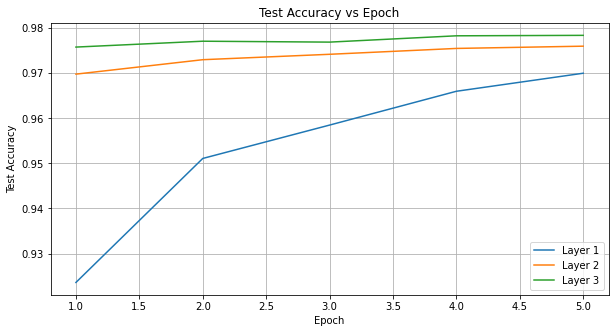

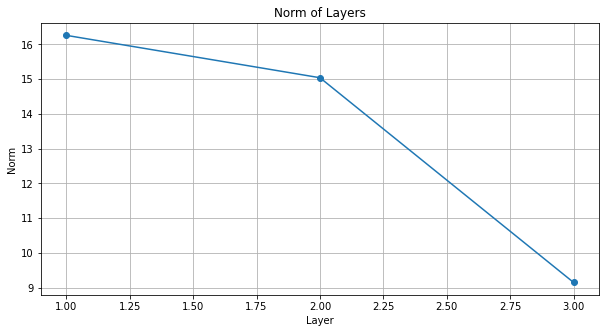

In [196]:
import matplotlib.pyplot as plt

# Plotting test accuracy
plt.figure(figsize=(10, 5))
for i, accuracy_history in enumerate(layer_test_accuracy_histories_cd, start=1):
    plt.plot(range(1, num_epochs + 1), accuracy_history, label=f'Layer {i}')
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy vs Epoch')
plt.legend()
plt.grid(True)
plt.show()

# Plotting norm of layers
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(layer_norms_cd) + 1), layer_norms_cd, marker='o', linestyle='-')
plt.xlabel('Layer')
plt.ylabel('Norm')
plt.title('Norm of Layers')
plt.grid(True)
plt.show()


### Layer wise SGD

In [197]:
layer_norms_sgd = []
layer_test_accuracy_histories_sgd = []
sgd = SGD(lr=0.03)
num_epochs = 5
x_train, y_train, x_test, y_test = load_data()
model = create_model()
print(model.layers)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
for i, layer in enumerate(model.layers[1:]): 
    print(f'Layer {i+1} Training')
    test_accuracy_history = []
    for l in model.layers:
        l.trainable =  (l == layer)
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        history = model.fit(x_train, y_train, batch_size=32, epochs=1)
        _, test_accuracy = model.evaluate(x_test, y_test, verbose=0)
        test_accuracy_history.append(test_accuracy)
        
    layer_test_accuracy_histories_sgd.append(test_accuracy_history)
    layer_weights = model.layers[i+1].get_weights()
    layer_norm = np.linalg.norm([np.linalg.norm(w) for w in layer_weights])
    layer_norms_sgd.append(layer_norm)
    print('Test accuracy:',layer_test_accuracy_histories_sgd)
    print('Norm of layer:',layer_norms_sgd)

[<keras.src.layers.reshaping.flatten.Flatten object at 0x00000211B7BE87C0>, <keras.src.layers.core.dense.Dense object at 0x00000211B75C7DC0>, <keras.src.layers.core.dense.Dense object at 0x00000211B75C7BE0>, <keras.src.layers.core.dense.Dense object at 0x00000211B3D56220>]
Layer 1 Training
Epoch 1/5
1875/1875 [==============================] - 5s 2ms/step - loss: 0.6330 - accuracy: 0.8387
Epoch 2/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2988 - accuracy: 0.9140
Epoch 3/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2484 - accuracy: 0.9286
Epoch 4/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2146 - accuracy: 0.9382
Epoch 5/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1885 - accuracy: 0.9457
Test accuracy: [[0.9096999764442444, 0.9261999726295471, 0.9341999888420105, 0.9437999725341797, 0.9502999782562256]]
Norm of layer: [15.494753]
Layer 2 Training
Epoch 1/5
1875/1875 [=====================

In [198]:
layerwise_ta_sgd=(layer_test_accuracy_histories_sgd[-1])[-1]
layerwise_ta_sgd

0.9710999727249146

In [199]:
layerwise_norm_sgd=np.prod(layer_norms_sgd)
layerwise_norm_sgd

1659.5975

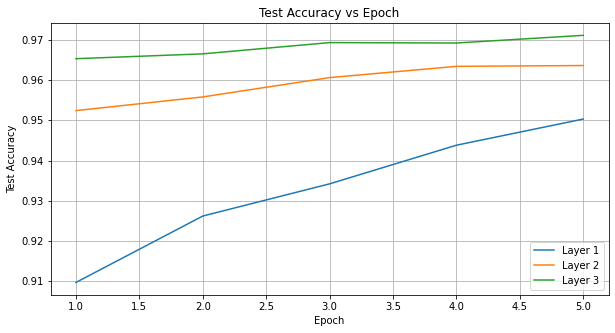

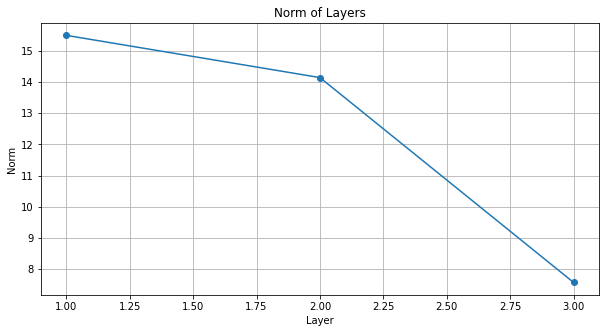

In [200]:
import matplotlib.pyplot as plt

# Plotting test accuracy
plt.figure(figsize=(10, 5))
for i, accuracy_history in enumerate(layer_test_accuracy_histories_sgd, start=1):
    plt.plot(range(1, num_epochs + 1), accuracy_history, label=f'Layer {i}')
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy vs Epoch')
plt.legend()
plt.grid(True)
plt.show()

# Plotting norm of layers
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(layer_norms_cd) + 1), layer_norms_sgd, marker='o', linestyle='-')
plt.xlabel('Layer')
plt.ylabel('Norm')
plt.title('Norm of Layers')
plt.grid(True)
plt.show()


## End to End and Layer-wise comparision

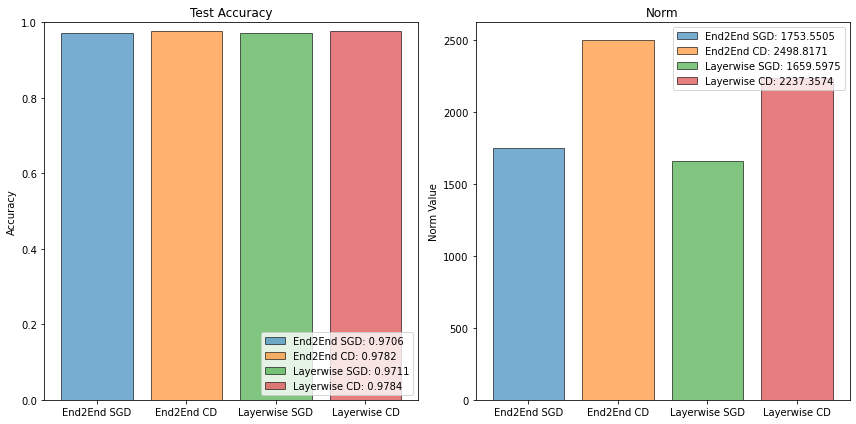

In [205]:
import matplotlib.pyplot as plt

# Plot graph
labels = ['End2End SGD', 'End2End CD', 'Layerwise SGD', 'Layerwise CD']
values_ta = [End2End_ta_sgd, End2End_ta_cd, layerwise_ta_sgd, layerwise_ta_cd]
values_norm = [End2End_norm_SGD, End2End_norm_CD, layerwise_norm_sgd, layerwise_norm_cd]

plt.figure(figsize=(12, 6))

# Plot Test Accuracy
plt.subplot(1, 2, 1)
for i, value in enumerate(values_ta):
    plt.bar(labels[i], value, color=f'C{i}', label=f'{labels[i]}: {value:.4f}', alpha=0.6, edgecolor='black')
plt.title('Test Accuracy')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.legend(loc='lower right')

# Plot Norm
plt.subplot(1, 2, 2)
for i, value in enumerate(values_norm):
    plt.bar(labels[i], value, color=f'C{i}', label=f'{labels[i]}: {value:.4f}', alpha=0.6, edgecolor='black')
plt.title('Norm')
plt.ylabel('Norm Value')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()


In [206]:
# Plot graph
labels = ['End2End SGD', 'End2End CD', 'Layerwise SGD', 'Layerwise CD']
values_ta = [End2End_ta_sgd, End2End_ta_cd, layerwise_ta_sgd, layerwise_ta_cd]
values_norm = [End2End_norm_SGD, End2End_norm_CD, layerwise_norm_sgd, layerwise_norm_cd]

print("Test Accuracy Values:", values_ta)
print("Norm Values:", values_norm)

Test Accuracy Values: [0.9706000089645386, 0.9782000184059143, 0.9710999727249146, 0.9783999919891357]
Norm Values: [1753.5505, 2498.8171, 1659.5975, 2237.3574]


### 1. Test error - do the above 2 algorithms achieve similar performance?

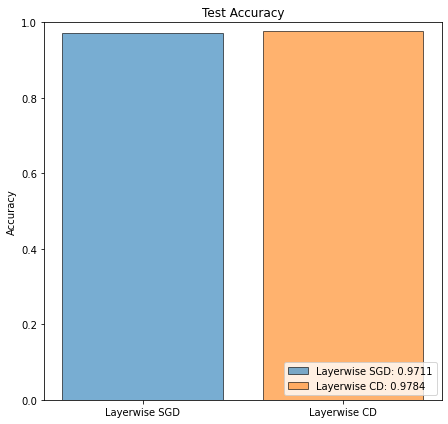

In [207]:
import matplotlib.pyplot as plt

# Plot graph
labels = [ 'Layerwise SGD', 'Layerwise CD']
values_ta = [layerwise_ta_sgd, layerwise_ta_cd]


plt.figure(figsize=(12, 6))

# Plot Test Accuracy
plt.subplot(1, 2, 1)
for i, value in enumerate(values_ta):
    plt.bar(labels[i], value, color=f'C{i}', label=f'{labels[i]}: {value:.4f}', alpha=0.6, edgecolor='black')
plt.title('Test Accuracy')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.legend(loc='lower right')


plt.tight_layout()
plt.show()


The difference in test accuracies between the Coordinate Descent (CD) and Stochastic Gradient Descent (SGD) optimization methods is minimal, indicating that both methods achieve similar performance in this scenario. This suggests that either optimization method could be effectively used for training the model, and the choice between them may depend on other factors such as computational efficiency, ease of implementation, or specific requirements of the problem at hand.

### 2.Norm of the neural network - do the above 3 algorithms find the same solutions in terms of the norm (defined as products of the norms of all the layers)?

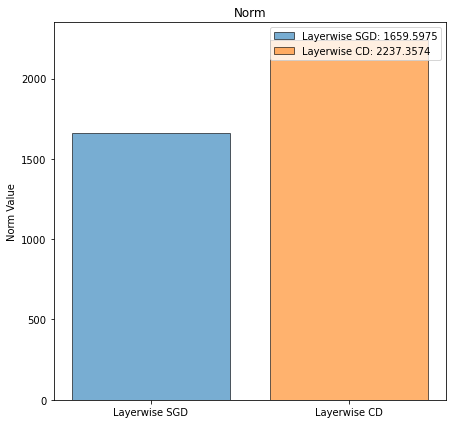

In [208]:
import matplotlib.pyplot as plt

# Plot graph
labels = [ 'Layerwise SGD', 'Layerwise CD']
values_norm = [layerwise_norm_sgd, layerwise_norm_cd]

plt.figure(figsize=(12, 6))


# Plot Norm
plt.subplot(1, 2, 2)
for i, value in enumerate(values_norm):
    plt.bar(labels[i], value, color=f'C{i}', label=f'{labels[i]}: {value:.4f}', alpha=0.6, edgecolor='black')
plt.title('Norm')
plt.ylabel('Norm Value')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()



No, it seems that the norms for the Coordinate Descent (CD) and Stochastic Gradient Descent (SGD) algorithms are not the same, indicating potential differences in the solutions found by these algorithms. This suggests that they may converge to different local minima or achieve different regularization effects during training.